## STERNUM

In [116]:
import pandas as pd
import numpy as np
from scipy import signal
import scipy.linalg as la
import pywt
import matplotlib.pyplot as plt


## Load the orginal data

In [17]:
DF = pd.read_csv('center_sternum.txt',sep='\t')  
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


## Select only the meaningful data

Al fine di selezionare un intervallo significativo dei dati raccolti, è stato eseguito un plot rappresentativo di AccX GyroX MagnX in funzione del tempo. Il tempo (in secondi) associato a ciascuna misura è stato derivato dalla frequenza di campionamento 'Log Freq' 0 200Hz.

Come intervallo signoficativo si è, dunque, tenuto quello compreso tra [7.5,70] s, come mostrato in figura. A questo punto il tempo è stato riscalato, in modo che la prima misurazione significativa corrisponda a 0s.

Text(0, 0.5, 'Magnetic Field [G]')

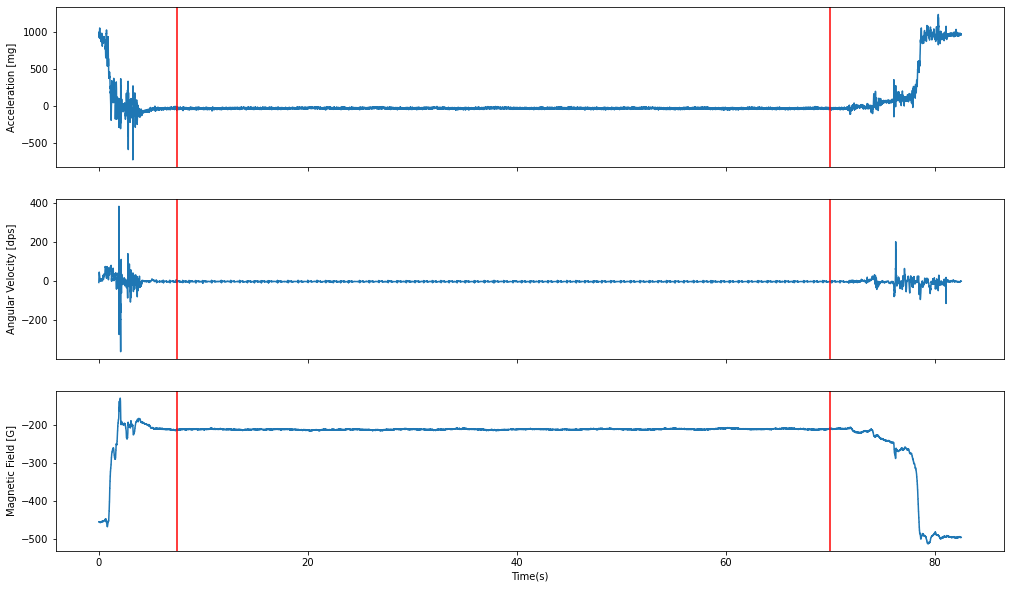

In [33]:
#raw data
(fig, (ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'])
ax1.axvline(x = 7.5, color = 'red')
ax1.axvline(x = 70, color = 'red')
ax1.set_ylabel('Acceleration [mg]')

ax2.plot(t, DF['GyroX'])
ax2.axvline(x = 7.5, color = 'red')
ax2.axvline(x = 70, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')

ax3.plot(t, DF['MagnX'])
ax3.axvline(x = 7.5, color = 'red')
ax3.axvline(x = 70, color = 'red')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Magnetic Field [mG?????]') 


Le colonne di maggior interesse sono quelle contenenti le misurazioni fatte da Accelerometro(mg), Giroscopio(dps) e relativi tempi(s). I dati di magnetometro e quaternioni sono stati scartati in quanto l'ampiezza del segnale non è sufficiente per proseguire nell'analisi, come si vede dal plot di 'MagnX' e 'qw'  in funzione del tempo, per un intervallo di 20s.

Text(0.5, 0, 'Time [s]')

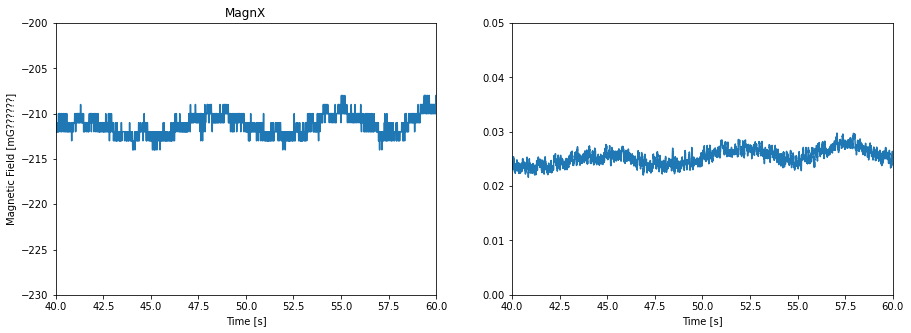

In [45]:
(fig, (ax1,ax2)) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(t,DF['MagnX'])
ax1.set_ylim(-230,-200)
ax1.set_xlim(40,60)
ax1.set_ylabel('Magnetic Field [mG??????]')
ax1.set_title('MagnX')
ax1.set_xlabel('Time [s]')

ax2.plot(t,DF['qw'])       ########
ax2.set_ylim(0,0.05)
ax2.set_xlim(40,60)
ax2.set_xlabel('Time [s]')

In [47]:
#new dataset
a = 1500
b = 14000
freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1) #TOGLIERE MAGN???
df['Time'] = np.arange(0, len(df['AccX']))/freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,-24.949,115.046,-951.661,0.687023,4.870229,1.511450,-212,-434,435,0.000
1501,-10.980,106.323,-971.059,1.358779,3.358779,1.099237,-212,-435,435,0.005
1502,-17.690,109.800,-970.022,1.068702,3.160305,0.702290,-213,-435,434,0.010
1503,-21.533,104.249,-965.630,0.687023,2.793893,0.381679,-213,-435,434,0.015
1504,-23.668,104.737,-967.033,0.305343,2.748092,0.778626,-214,-435,435,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-30.866,118.767,-941.108,-3.175573,3.358779,-0.778626,-210,-430,427,62.480
13997,-32.818,118.279,-942.145,-2.992366,3.679389,-0.549618,-210,-430,427,62.485
13998,-22.692,113.704,-948.184,-3.022901,3.786260,-0.564885,-211,-432,427,62.490
13999,-38.674,119.743,-937.143,-2.854962,3.419847,-0.885496,-211,-432,427,62.495


## Calibration

Di seguito è riportata la procedura di calibrazione eseguita sul dataset.

In [19]:
#calibration matrices and offset vectors
gyro_off = np.array([-2.242224,2.963463,-0.718397])
acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_off = np.array([-3.929942,-13.74679,60.67546])
magn_cal=np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_off=np.array([-95.67974,-244.9142,17.71132])

In [20]:
#calibration procedure
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_off.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_cal.T) + acc_off.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1500,-28.504953,100.373720,-894.980558,-1.555201,7.833692,0.793053,-278.962788,-635.189046,395.663599,0.000
1501,-14.488596,91.833874,-914.453062,-0.883445,6.322242,0.380840,-278.939536,-636.103922,395.659342,0.005
1502,-21.213892,95.250842,-913.412547,-1.173522,6.123768,-0.016107,-279.862302,-636.084927,394.781061,0.010
1503,-25.050763,89.820226,-908.991605,-1.555201,5.757356,-0.336718,-279.862302,-636.084927,394.781061,0.015
1504,-27.187979,90.304963,-910.399517,-1.936881,5.711555,0.060229,-280.778107,-636.057418,395.652380,0.020
...,...,...,...,...,...,...,...,...,...,...
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023,-277.245071,-631.610104,388.689191,62.480
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015,-277.245071,-631.610104,388.689191,62.485
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282,-278.117853,-633.416605,388.677195,62.490
13999,-42.264295,104.980254,-880.401686,-5.097186,6.383310,-1.603893,-278.117853,-633.416605,388.677195,62.495


## Statistical analysis:

Mean, median, variance, standard deviation, 25th and 75th percentiles:

In [48]:
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-30.745810,115.404149,-949.378397,-2.086497,3.681306,-0.866868,-211.612431,-432.359171,429.891209
median,-30.683000,115.656000,-949.770000,-2.152672,3.633588,-0.854962,-212.000000,-432.000000,430.000000
variance,49.680771,30.503301,210.815826,2.080482,0.532462,0.145359,1.743618,3.838666,8.913604
standard deviation,7.048459,5.522979,14.519498,1.442388,0.729700,0.381260,1.320461,1.959251,2.985566
25% percentile,-35.380000,111.935000,-958.066000,-2.702290,3.267176,-1.114504,-212.000000,-434.000000,427.000000
75% percentile,-26.047000,119.072000,-941.413000,-1.465649,4.000000,-0.625954,-211.000000,-431.000000,433.000000


Correlation coefficients:

In [34]:
M = df.loc[:,:'MagnZ'].corr()  #Pearson   notare correlazioni >0.3
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.207281,-0.420923,0.207533,0.007652,0.032781,-0.387136,-0.081957,0.114785
AccY,-0.207281,1.000000,0.140504,-0.041180,-0.001382,-0.133480,0.274671,0.304631,-0.466504
AccZ,-0.420923,0.140504,1.000000,-0.074725,0.125339,0.016920,0.129940,0.143495,-0.211160
GyroX,0.207533,-0.041180,-0.074725,1.000000,0.395109,0.385103,-0.061540,-0.044704,0.013871
GyroY,0.007652,-0.001382,0.125339,0.395109,1.000000,0.441398,0.014606,-0.141403,0.013838
GyroZ,0.032781,-0.133480,0.016920,0.385103,0.441398,1.000000,-0.013101,-0.078795,0.017769
MagnX,-0.387136,0.274671,0.129940,-0.061540,0.014606,-0.013101,1.000000,0.291389,-0.360987
MagnY,-0.081957,0.304631,0.143495,-0.044704,-0.141403,-0.078795,0.291389,1.000000,-0.692741
MagnZ,0.114785,-0.466504,-0.211160,0.013871,0.013838,0.017769,-0.360987,-0.692741,1.000000


## PCA

Dal momento che le misurazioni di accelerazione e velocità angolare sono state fatte lungo i tre assi, si è applicata l'analisi PCA per stabilire quale di queste componenti portasse l'informazione maggiore.

In [50]:
cov_mat_acc=np.cov(df[['AccX','AccY','AccZ']].T)
a,b=la.eig(cov_mat_acc)

cov_mat_gyro=np.cov(df[['GyroX','GyroY','GyroZ']].T)
c,d=la.eig(cov_mat_gyro)

cov_mat_magn=np.cov(df[['MagnX','MagnY','MagnZ']].T)
e,f=la.eig(cov_mat_magn)

In [62]:
print('eigenvalues and eigenvectors (Acc): \n', a, '\n\n',b, '\n')
print('eigenvalues and eigenvectors (Gyro): \n', c, '\n\n',d, '\n')
print('eigenvalues and eigenvectors (Magn): \n', e, '\n\n',f, '\n')

eigenvalues and eigenvectors (Acc): 
 [222.07277852+0.j  40.5539064 +0.j  28.37321233+0.j] 

 [[ 0.23580201 -0.9301006  -0.28162081]
 [-0.08003146  0.27022237 -0.95946591]
 [-0.96850007 -0.24878251  0.01071833]] 

eigenvalues and eigenvectors (Gyro): 
 [2.21252496+0.j 0.43814605+0.j 0.10763217+0.j] 

 [[ 0.96234803  0.26653218 -0.05335597]
 [ 0.2491525  -0.94340978 -0.21886303]
 [ 0.10867058 -0.19732864  0.9742957 ]] 

eigenvalues and eigenvectors (Magn): 
 [11.68461765+0.j  1.52477192+0.j  1.28649788+0.j] 

 [[ 0.15160304  0.9568078   0.2480632 ]
 [ 0.49346575 -0.29071524  0.81974154]
 [-0.85645086  0.00186462  0.51622519]] 



Le prima componente principale comprende il tot% di variabilità.

I dati sono stati ruotati nel nuovo sistema di riferimento:

In [63]:
#rotation
rot = np.dot(df[['AccX','AccY','AccZ']],b)
rot1 = np.dot(df[['GyroX','GyroY','GyroZ']],d)
rot2 = np.dot(df[['MagnX','MagnY','MagnZ']],f)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2],
                    'Magn1': rot2[:,0], 'Magn2': rot2[:,1],'Magn3': rot2[:,2]})

dfr['Time'] = df['Time'].values
dfr


,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Magn1,Magn2,Magn3,Time
0,906.593419,291.049695,-113.556773,2.038835,-4.709760,0.370029,-618.860102,-75.861730,-183.799269,0.000
1,929.372416,280.525853,-109.329227,2.263921,-3.023458,0.263370,-619.353568,-75.571015,-184.619011,0.005
2,926.507581,287.448404,-110.764500,1.892179,-2.835201,-0.064457,-618.648720,-76.529687,-185.383299,0.010
3,921.791996,288.430123,-104.309161,1.398738,-2.527989,-0.276268,-618.648720,-76.529687,-185.383299,0.015
4,922.608309,290.896799,-104.191158,1.063154,-2.664838,0.140864,-619.656774,-77.484630,-185.115137,0.020
...,...,...,...,...,...,...,...,...,...,...
12496,894.679801,294.933196,-115.347485,-2.303772,-3.861452,-1.324289,-609.731427,-75.125892,-184.153978,62.480
12497,895.262905,296.874871,-114.340657,-2.022696,-4.160278,-1.181112,-609.731427,-75.125892,-184.153978,62.485
12498,903.865552,287.722803,-112.867521,-2.027113,-4.266227,-1.217748,-610.869961,-75.501270,-186.041525,62.490
12499,888.920445,301.472736,-114.042530,-1.991631,-3.812523,-1.458884,-610.869961,-75.501270,-186.041525,62.495


Text(0.5, 0, 'Time(s)')

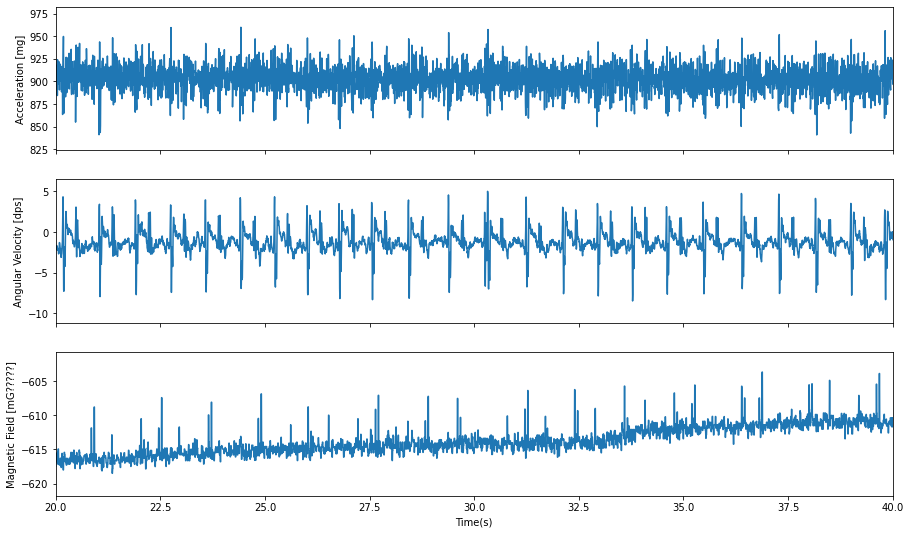

In [69]:
#principal components plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,9),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'])
ax[0].set_ylabel('Acceleration [mg]')
ax[1].plot(dfr['Time'],dfr['Gyro1'])
ax[1].set_ylabel('Angular Velocity [dps]')
ax[2].plot(dfr['Time'],dfr['Magn1'])
ax[2].set_ylabel('Magnetic Field [mG?????]')

ax[2].set_xlim(20,40)
ax[2].set_xlabel('Time(s)')


## FFT analysis

Per ciascuna componente principale è stata calcolata la FFT per evidenziare la frequenza cardiaca nello spettro, tra 40BPM e 100BPM.

1.1519078473722102
1.1519078473722102


Text(0.5, 0, 'Frequencies [Hz]')

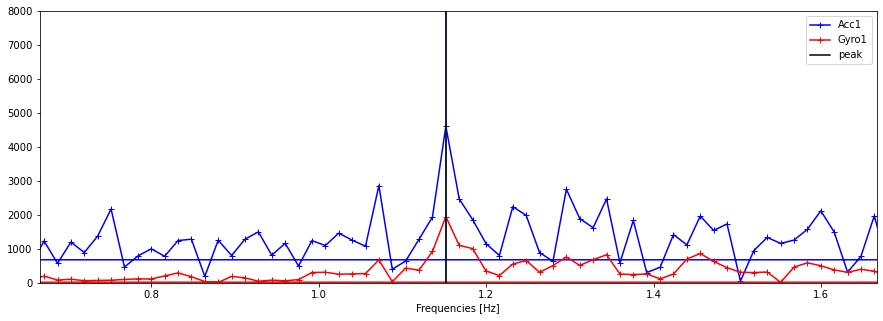

In [114]:
#select heart-beat freq
min_f=40./60.
max_f=100./60.

A1_FFT = np.abs(np.fft.fft(dfr['Acc1']-np.mean(dfr['Acc1'])))
G1_FFT = np.abs(np.fft.fft(dfr['Gyro1']-np.mean(dfr['Gyro1'])))

freq_FFT = np.fft.fftfreq(d=1/freq, n=len(A1_FFT))

X=[]
YA=[]
YG=[]
for i in range(len(A1_FFT)):
    if freq_FFT[i]<=max_f and freq_FFT[i]>=min_f:
        X.append(freq_FFT[i])
        YA.append(A1_FFT[i])
        YG.append(G1_FFT[i])
        
peakA,_ = signal.find_peaks(YA, height=4000)
peakG,_ = signal.find_peaks(YG, height=1500)
print(X[peakA[0]])
print(X[peakG[0]])
#print(X[peakG[0]]*60)

plt.figure(figsize = (15,5))
plt.plot(freq_FFT, A1_FFT,'b-+', label='Acc1')
plt.plot(freq_FFT, G1_FFT,'r-+', label='Gyro1')
plt.axvline(x = X[peakA[0]])
plt.axvline(x = X[peakG[0]], color='k', label='peak')
plt.xlim(min_f, max_f)
plt.ylim(0,8000)
plt.legend(loc='best')
plt.xlabel('Frequencies [Hz]')

Dallo spettro si nota chiaramente un picco, coincidente per entrambi i dataset, attorno a 1.15, che corrisponde ad un BPM di 69.

## SIGNAL FILTERING

Il segnale è stato pulito con una serie di filtri, in modo da evidenziare il battito cardiaco. 

- wavelet transform
- Hilbert envelop
- Butterworth filter (40-200)BPM


In [115]:
sigA = dfr['Acc1']
sigG = dfr['Gyro1']
sigM = dfr['Magn1']
t = dfr['Time']

## Accelerometer

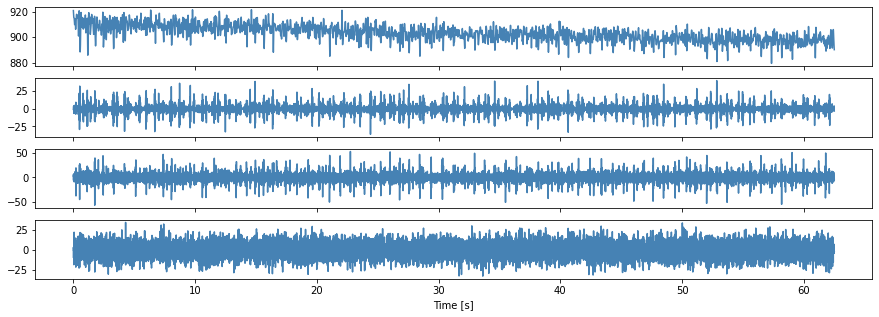

In [177]:
# WAVELET ACC
n = 3
cA = pywt.wavedec(sigA, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = cA.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
ax[n].set_xlabel('Time [s]')
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'steelblue')

Text(0.5, 0, 'Time [s]')

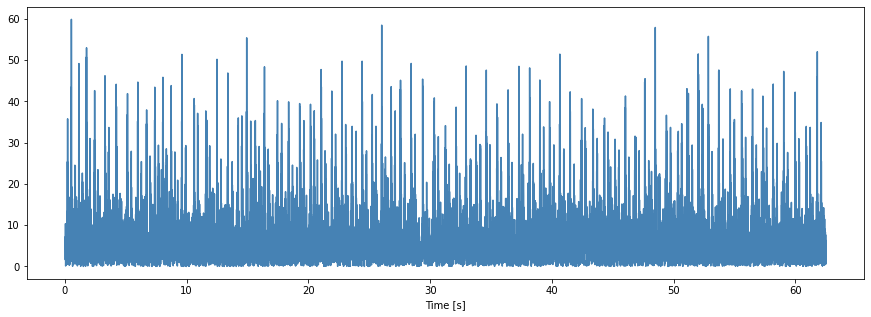

In [178]:
ca = cA.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigA_w = pywt.waverec(ca, 'bior5.5')

plt.figure(figsize=(15,5))
plt.plot(t, np.abs(sigA_w[:-1]), color = 'steelblue')
plt.xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

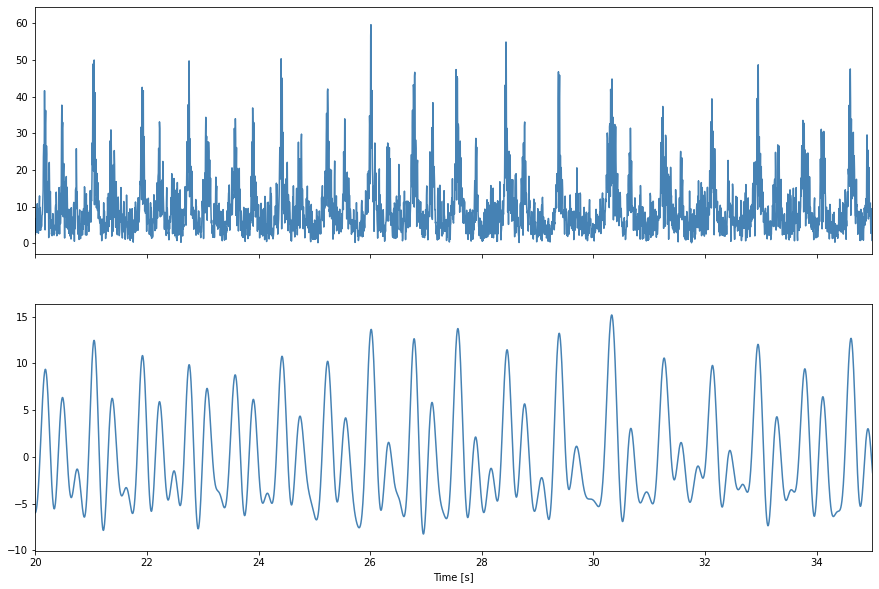

In [190]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10), sharex=True)

# Hilbert
SIG = np.abs(sigA_w[:-1])
SIG_h = signal.hilbert(SIG)
#ax1.plot(t, SIG[:])
ax1.plot(t, np.abs(SIG_h[:]), color = 'steelblue')

# Butterworth
b, a = signal.butter(4, Wn=[0.67/100, 4/100], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, np.abs(SIG_h))
ax2.plot(t, filtered_data_butterworth[:], color = 'steelblue')
ax2.set_xlim(20, 35)
ax2.set_xlabel('Time [s]')

## Gyroscope

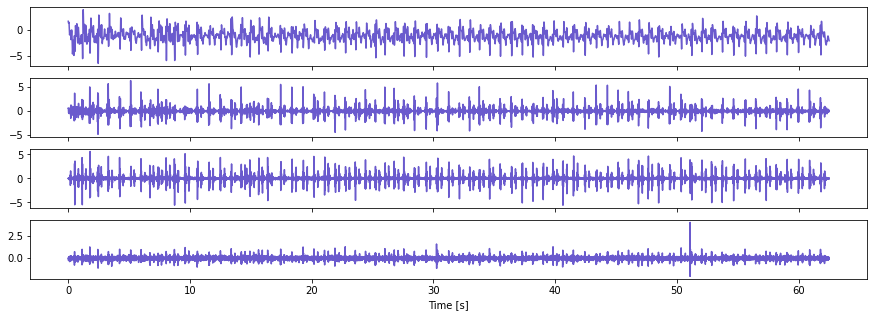

In [191]:
# WAVELET GYRO
n = 3
cG = pywt.wavedec(sigG, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = cG.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
ax[n].set_xlabel('Time [s]')
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'slateblue')

Text(0.5, 0, 'Time [s]')

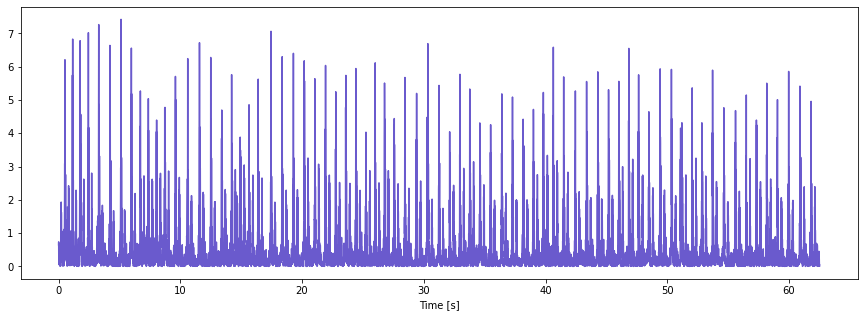

In [192]:
ca = cG.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigG_w = pywt.waverec(ca, 'bior5.5')

plt.figure(figsize=(15,5))
plt.plot(t, np.abs(sigG_w[:-1]), color = 'slateblue')
plt.xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

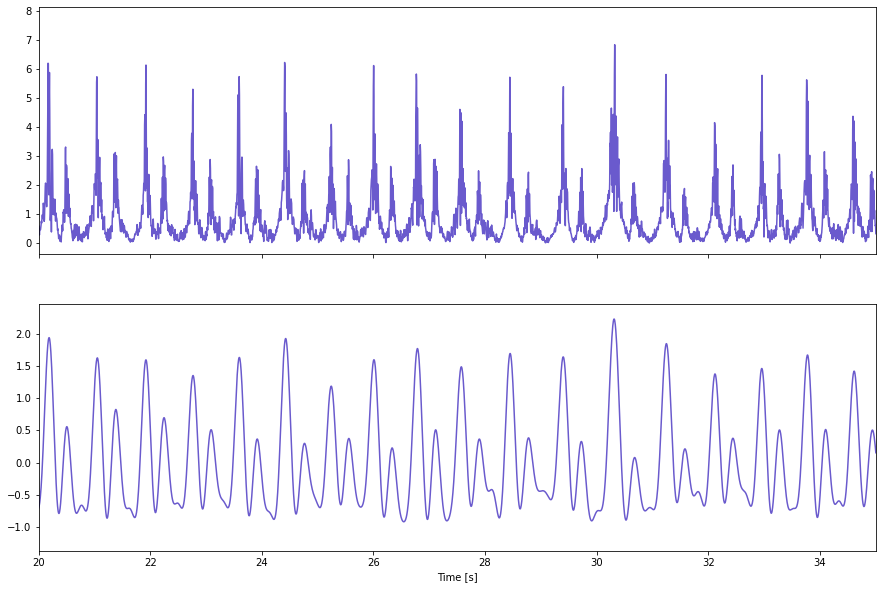

In [193]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10), sharex=True)

# Hilbert
SIG = np.abs(sigG_w[:-1])
SIG_h = signal.hilbert(SIG)
#ax1.plot(t, SIG[:])
ax1.plot(t, np.abs(SIG_h[:]), color = 'slateblue')

# Butterworth
b, a = signal.butter(4, Wn=[0.67/100, 4/100], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, np.abs(SIG_h))
ax2.plot(t, filtered_data_butterworth[:], color = 'slateblue')
ax2.set_xlim(20, 35)
ax2.set_xlabel('Time [s]')

## Magnetometer

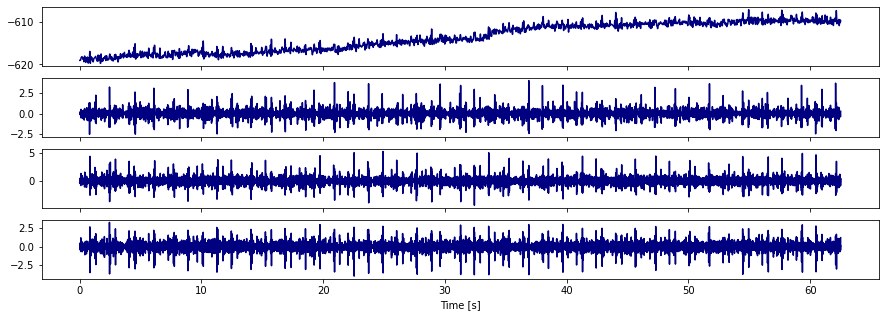

In [194]:
# WAVELET MAGN
n = 3
cM = pywt.wavedec(sigM, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = cM.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
ax[n].set_xlabel('Time [s]')
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'navy')

Text(0.5, 0, 'Time [s]')

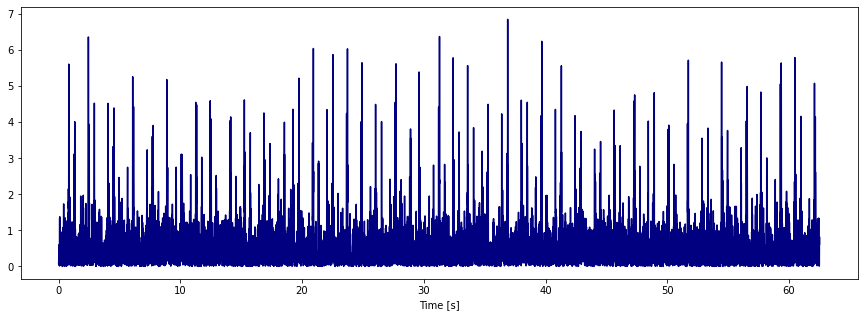

In [195]:
ca = cM.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigM_w = pywt.waverec(ca, 'bior5.5')

plt.figure(figsize=(15,5))
plt.plot(t, np.abs(sigM_w[:-1]), color = 'navy')
plt.xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

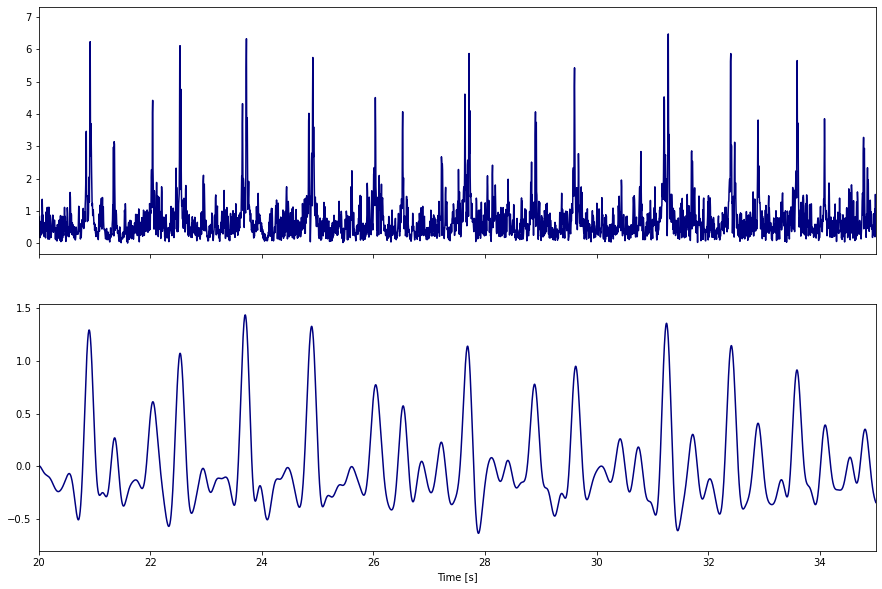

In [196]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10), sharex=True)

# Hilbert
SIG = np.abs(sigM_w[:-1])
SIG_h = signal.hilbert(SIG)
#ax1.plot(t, SIG[:])
ax1.plot(t, np.abs(SIG_h[:]), color = 'navy')

# Butterworth
b, a = signal.butter(4, Wn=[0.67/100, 4/100], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, np.abs(SIG_h))
ax2.plot(t, filtered_data_butterworth[:], color = 'navy')
ax2.set_xlim(20, 35)
ax2.set_xlabel('Time [s]')